# **قسمت  الف:**

--2025-04-20 07:11:40--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  22.2MB/s    in 0.4s    

2025-04-20 07:11:41 (22.2 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-20 07:11:41--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28

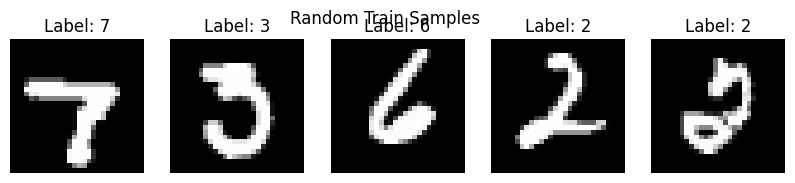

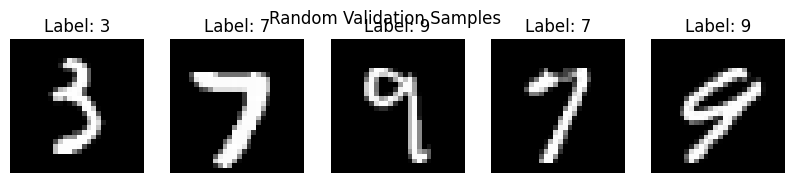

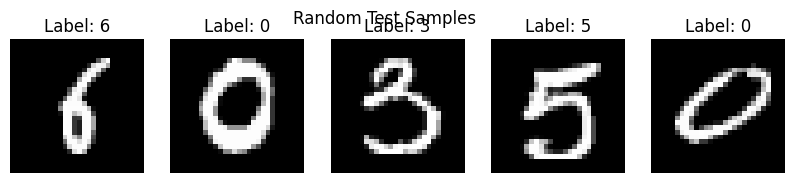

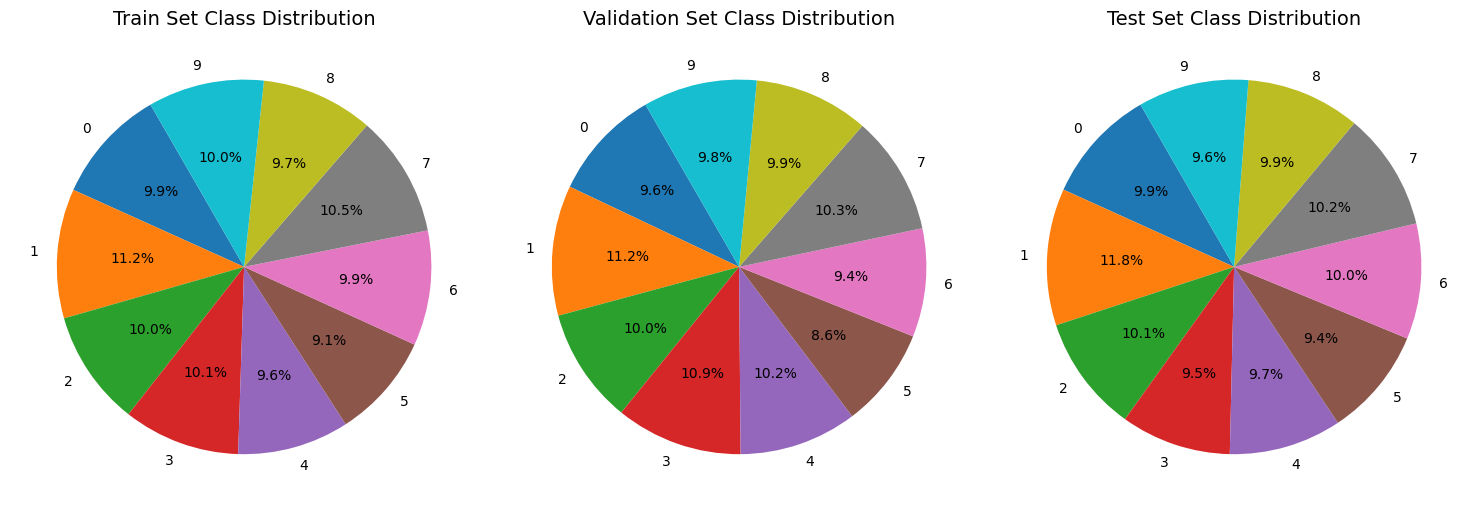

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import os
import gzip

np.random.seed(42)

def load_mnist_data():
    base_path = '/content/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }

    base_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
    for name, file in files.items():
        if not os.path.exists(base_path + file):
            print(f"Downloading {file}...")
            !wget -P {base_path} {base_url + file}

    for name, file in files.items():
        with gzip.open(base_path + file, 'rb') as f:
            if 'images' in name:
                data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
            else:
                data = np.frombuffer(f.read(), np.uint8, offset=8)
            globals()[name] = data

    return train_images, train_labels, test_images, test_labels

try:
    train_images, train_labels, test_images, test_labels = load_mnist_data()
except Exception as e:
    print(f"Error loading data: {e}")
    raise

def split_data(images_train, labels_train, images_test, labels_test):
    all_images = np.concatenate((images_train, images_test), axis=0)
    all_labels = np.concatenate((labels_train, labels_test), axis=0)

    num_samples = len(all_images)

    train_size = int(num_samples * 0.7)  # 70%
    valid_size = int(num_samples * 0.2)  # 20%
    test_size = num_samples - train_size - valid_size  # 10%

    
    indices = np.random.permutation(num_samples)

    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]

    train_images = all_images[train_indices]
    train_labels = all_labels[train_indices]
    valid_images = all_images[valid_indices]
    valid_labels = all_labels[valid_indices]
    test_images = all_images[test_indices]
    test_labels = all_labels[test_indices]

    return train_images, train_labels, valid_images, valid_labels, test_images, test_labels

train_images, train_labels, valid_images, valid_labels, test_images, test_labels = split_data(
    train_images, train_labels, test_images, test_labels
)

print(f"Train samples: {len(train_images)}")
print(f"Valid samples: {len(valid_images)}")
print(f"Test samples: {len(test_images)}")

def show_random_samples(images, labels, num_samples=5, title='Random Samples'):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_random_samples(train_images, train_labels, title='Random Train Samples')
show_random_samples(valid_images, valid_labels, title='Random Validation Samples')
show_random_samples(test_images, test_labels, title='Random Test Samples')


def plot_class_distribution_pie_horizontal(train_labels, valid_labels, test_labels):
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    unique_valid, counts_valid = np.unique(valid_labels, return_counts=True)
    unique_test, counts_test = np.unique(test_labels, return_counts=True)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].pie(counts_train, labels=unique_train, autopct='%1.1f%%', startangle=120, textprops={'fontsize': 10})
    axes[0].set_title('Train Set Class Distribution', fontsize=14)

    axes[1].pie(counts_valid, labels=unique_valid, autopct='%1.1f%%', startangle=120, textprops={'fontsize': 10})
    axes[1].set_title('Validation Set Class Distribution', fontsize=14)

    axes[2].pie(counts_test, labels=unique_test, autopct='%1.1f%%', startangle=120, textprops={'fontsize': 10})
    axes[2].set_title('Test Set Class Distribution', fontsize=14)

    plt.tight_layout()
    plt.show()

plot_class_distribution_pie_horizontal(train_labels, valid_labels, test_labels)




## قسمت  ب :

In [ ]:
train_images = train_images.astype('float32') / 255.0
valid_images = valid_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_images = train_images.reshape(-1, 28*28)
valid_images = valid_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)

train_labels_one_hot = keras.utils.to_categorical(train_labels, 10)
valid_labels_one_hot = keras.utils.to_categorical(valid_labels, 10)
test_labels_one_hot = keras.utils.to_categorical(test_labels, 10)

class CustomMNISTDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = CustomMNISTDataset(train_images, train_labels_one_hot)
valid_dataset = CustomMNISTDataset(valid_images, valid_labels_one_hot)
test_dataset = CustomMNISTDataset(test_images, test_labels_one_hot)


def build_model(hidden_layers, dropout_rate, l2_lambda):
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_dim=28*28, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_lambda)))
    model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(l2_lambda)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation='softmax'))
    return model

# param_grid = {
#     'hidden_layers': [[512], [256, 128], [512, 256, 128]],
#     'dropout_rate': [0.3, 0.5],
#     'l2_lambda': [0.0, 0.01],
#     'lr': [0.001, 0.01]
# }
param_grid = {
    'hidden_layers': [ [512, 256, 128]],
    'dropout_rate': [0.5],
    'l2_lambda': [0.0],
    'lr': [0.001]
}

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    model = build_model(params['hidden_layers'], params['dropout_rate'], params['l2_lambda'])
    optimizer = Adam(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_images, train_labels_one_hot, epochs=5, batch_size=64,
                        validation_data=(valid_images, valid_labels_one_hot), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    print(f'Params: {params}, Validation Accuracy: {accuracy*100:.2f}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f'Best Params: {best_params}, Best Validation Accuracy: {best_accuracy*100:.2f}%')

# آموزش مدل نهایی با بهترین پارامترها
final_model = build_model(best_params['hidden_layers'], best_params['dropout_rate'], best_params['l2_lambda'])
optimizer = Adam(learning_rate=best_params['lr'])
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = final_model.fit(train_images, train_labels_one_hot, epochs=10, batch_size=64,
                          validation_data=(valid_images, valid_labels_one_hot))

# # نمایش نتایج
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

test_loss, test_accuracy = final_model.evaluate(test_images, test_labels_one_hot)
print(f'Final Test Accuracy: {test_accuracy*100:.2f}%')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: {'dropout_rate': 0.5, 'hidden_layers': [512, 256, 128], 'l2_lambda': 0.0, 'lr': 0.001}, Validation Accuracy: 97.13%
Best Params: {'dropout_rate': 0.5, 'hidden_layers': [512, 256, 128], 'l2_lambda': 0.0, 'lr': 0.001}, Best Validation Accuracy: 97.13%
Epoch 1/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7008 - loss: 0.8939 - val_accuracy: 0.9464 - val_loss: 0.1767
Epoch 2/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9314 - loss: 0.2470 - val_accuracy: 0.9601 - val_loss: 0.1356
Epoch 3/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9452 - loss: 0.1943 - val_accuracy: 0.9679 - val_loss: 0.1154
Epoch 4/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9518 - loss: 0.1719 - val_accuracy: 0.9706 - val_loss: 0.1089
Epoch 5/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9593 - loss: 0.1457 - val_accuracy: 0.9719 - val_loss: 0.0980
Epoch 6/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9623 - loss: 0.1317 - val_accuracy: 

In [ ]:
final_model.save('mnist_model.h5')
print("مدل به صورت کامل در فایل 'mnist_model.h5' ذخیره شد.")

مدل به صورت کامل در فایل 'mnist_model.h5' ذخیره شد.


**برای تست مدل روی داده های تست به صورت تک تک **

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


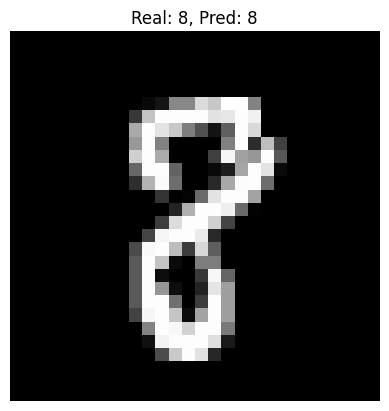

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(test_images) - 1)

image = test_images[idx]
true_label = test_labels[idx]

image_flat = image.reshape(1, -1)

prediction = final_model.predict(image_flat)
predicted_label = np.argmax(prediction, axis=1)[0]

image_reshaped = image.reshape(28, 28)

# نمایش تصویر
plt.imshow(image_reshaped, cmap='gray')
plt.title(f"Real: {true_label}, Pred: {predicted_label}")
plt.axis('off')
plt.show()


# **قسمت پ :**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


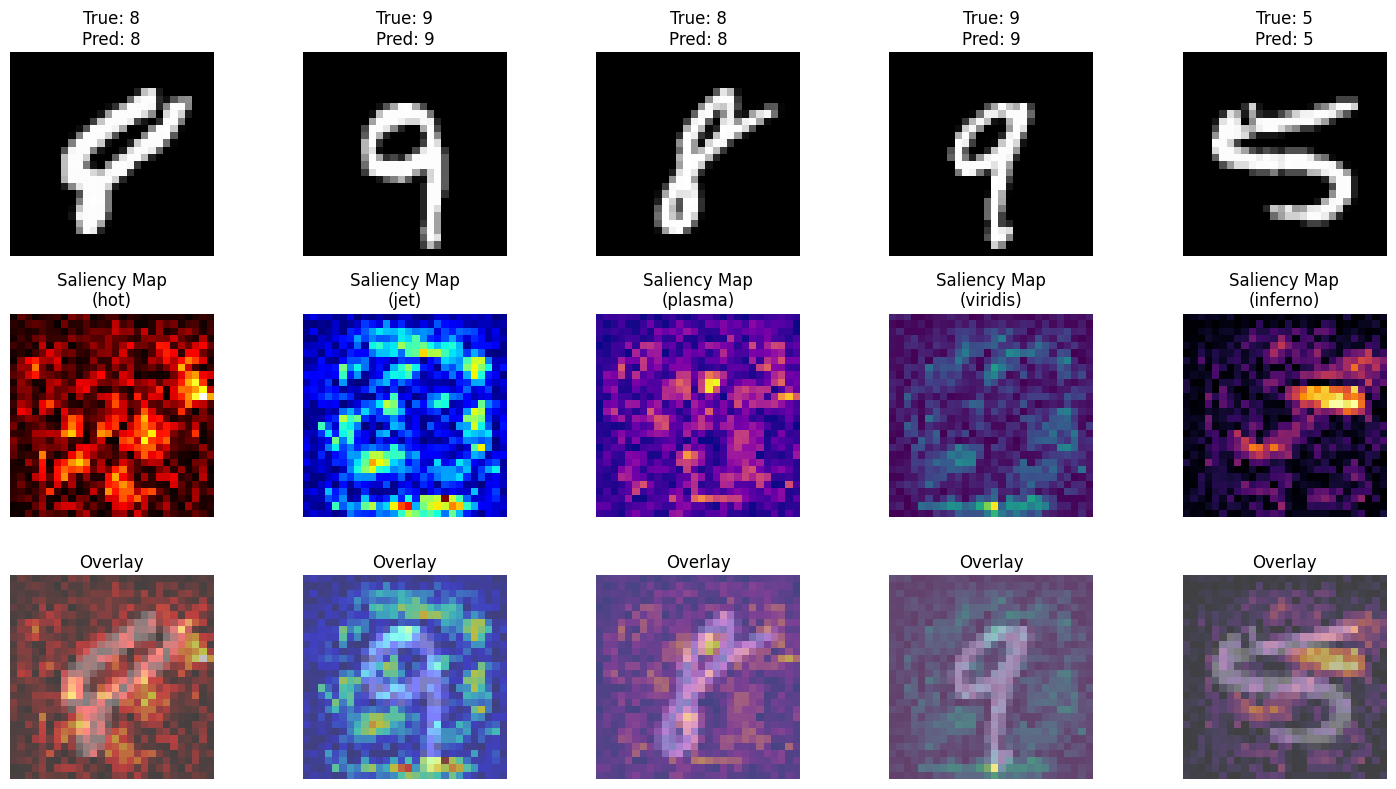

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf

test_images_flat = test_images  


# مشتق خروجی کلاس نسبت به پیکسلِ ورودی چقدر بزرگ است؟»
# هر چه قدر این مشتق بزرگ‌تر باشد، یعنی تغییر کوچک در آن پیکسل بیش از دیگر پیکسل‌ها بر پیش‌بینی تأثیر می‌گذارد.


def compute_saliency_map(model, image):
    image_tensor = tf.convert_to_tensor(image[np.newaxis, :], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        predicted_label = tf.argmax(predictions[0])
        loss = predictions[0, predicted_label]

    grads = tape.gradient(loss, image_tensor)
    saliency = tf.abs(grads).numpy()[0]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency.reshape(28, 28)

colormaps = ['hot', 'jet', 'plasma', 'viridis', 'inferno']


num_samples = 5
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    image = test_images[idx].reshape(28, 28)
    true_label = test_labels[idx]
    saliency_map = compute_saliency_map(final_model, test_images_flat[idx])

    pred = final_model.predict(test_images_flat[idx][np.newaxis, :])
    pred_label = np.argmax(pred)

    plt.subplot(3, num_samples, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')

    plt.subplot(3, num_samples, i + 1 + num_samples)
    cmap = colormaps[i % len(colormaps)]
    plt.imshow(saliency_map, cmap=cmap)
    plt.title(f'Saliency Map\n({cmap})')
    plt.axis('off')

    plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(image, cmap='gray', alpha=0.5)
    plt.imshow(saliency_map, cmap=cmap, alpha=0.5)
    plt.title('Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **قسمت ت:**

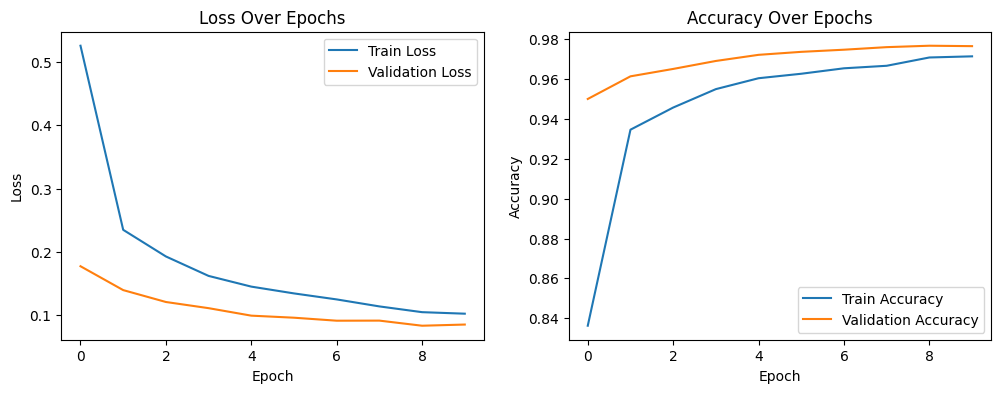

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


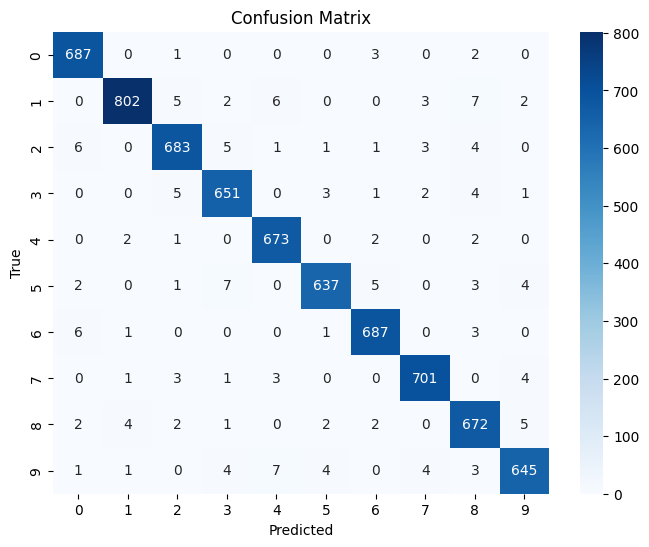

Total number of parameters: 567434
Test Accuracy: 97.69%
Precision (macro): 0.9767
Recall (macro): 0.9769
F1 Score (macro): 0.9767


In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_predictions = final_model.predict(test_images_flat)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_labels

cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

total_params = final_model.count_params()
print(f"Total number of parameters: {total_params}")

accuracy = final_model.evaluate(test_images_flat, test_labels_one_hot, verbose=0)[1]
precision = precision_score(test_true_labels, test_pred_labels, average='macro')
recall = recall_score(test_true_labels, test_pred_labels, average='macro')
f1 = f1_score(test_true_labels, test_pred_labels, average='macro')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

# **قسمت  ث:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


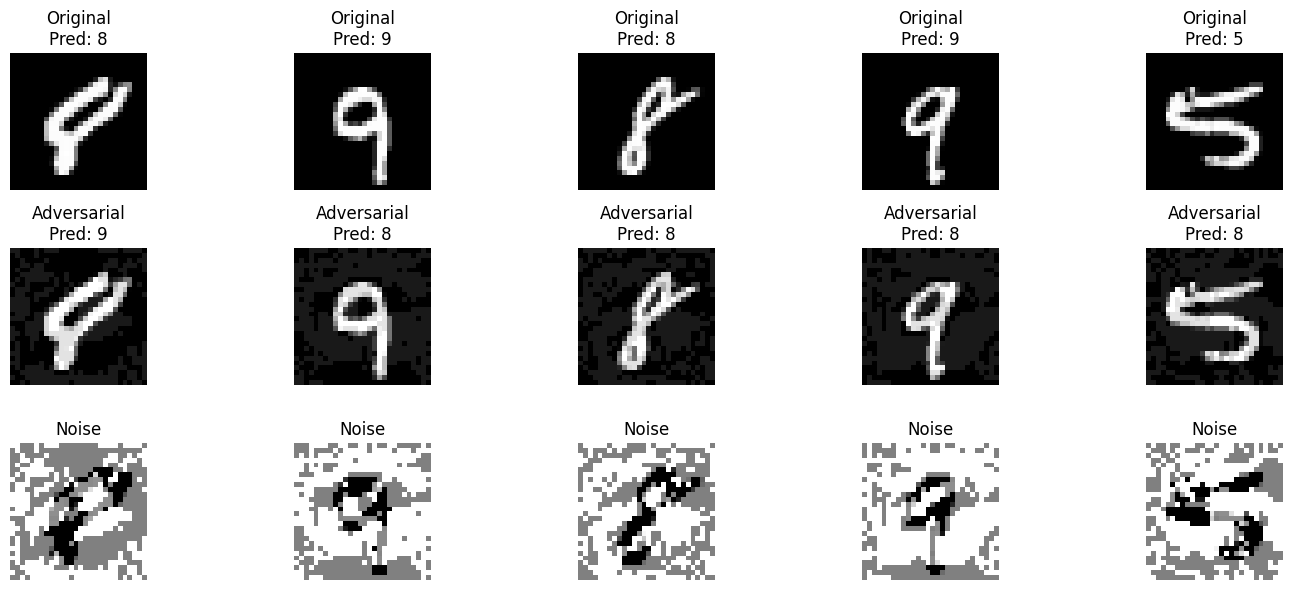

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


test_images_flat = test_images.reshape(-1, 28*28) 
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, 10)


def fgsm_attack(model, image, label, epsilon=0.1):

    image_tensor = tf.convert_to_tensor(image[np.newaxis, :], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        loss = tf.keras.losses.categorical_crossentropy(label[np.newaxis, :], predictions)

    gradient = tape.gradient(loss, image_tensor)
    signed_grad = tf.sign(gradient)
    adversarial_image = image_tensor + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image.numpy()[0]

num_samples = 5
sample_indices = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    image = test_images_flat[idx]
    label = test_labels_one_hot[idx]
    adv_image = fgsm_attack(final_model, image, label, epsilon=0.1)

    pred_orig = np.argmax(final_model.predict(image[np.newaxis, :]))
    pred_adv = np.argmax(final_model.predict(adv_image[np.newaxis, :]))

    plt.subplot(3, num_samples, i + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'Original\nPred: {pred_orig}')
    plt.axis('off')

    plt.subplot(3, num_samples, i + 1 + num_samples)
    plt.imshow(adv_image.reshape(28, 28), cmap='gray')
    plt.title(f'Adversarial\nPred: {pred_adv}')
    plt.axis('off')

    plt.subplot(3, num_samples, i + 1 + 2*num_samples)
    plt.imshow((adv_image - image).reshape(28, 28), cmap='gray')
    plt.title('Noise')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **قسمت  ج:**

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


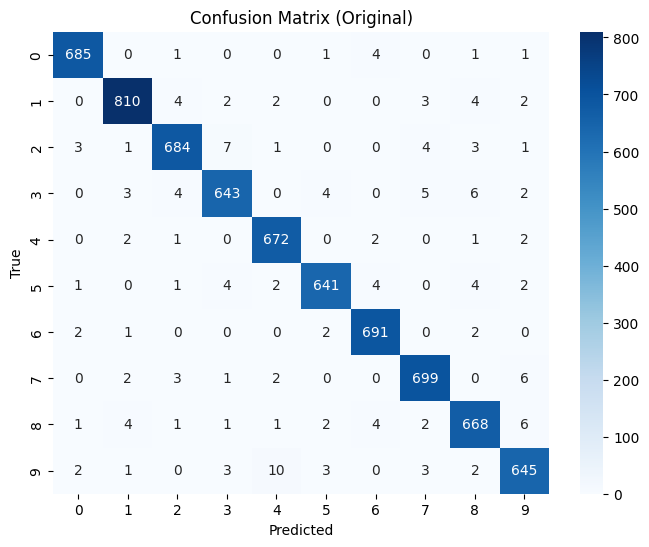

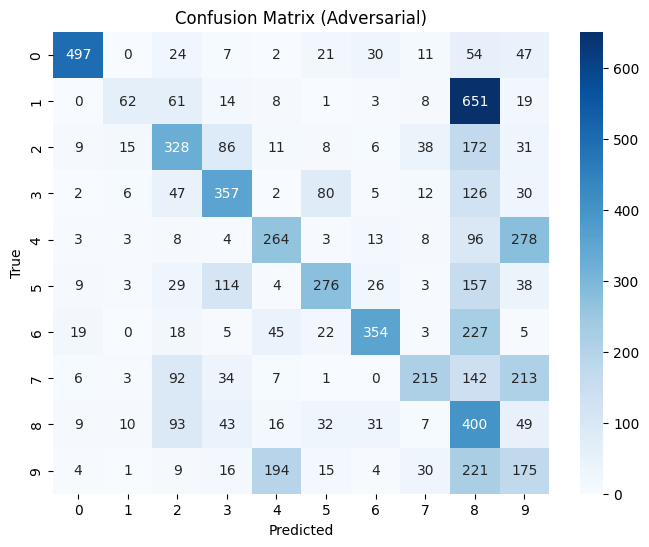

Total number of parameters: 567434
Before Attack:
Test Accuracy: 97.69%
Precision (macro): 0.9767
Recall (macro): 0.9767
F1 Score (macro): 0.9767

After Attack:
Test Accuracy: 41.83%
Precision (macro): 0.5327
Recall (macro): 0.4250
F1 Score (macro): 0.4357


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

adv_images = np.array([fgsm_attack(final_model, test_images_flat[i], test_labels_one_hot[i], epsilon=0.1)
                       for i in range(len(test_images))])

orig_predictions = final_model.predict(test_images_flat)
orig_pred_labels = np.argmax(orig_predictions, axis=1)

adv_predictions = final_model.predict(adv_images)
adv_pred_labels = np.argmax(adv_predictions, axis=1)

cm_orig = confusion_matrix(test_labels, orig_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Original)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

cm_adv = confusion_matrix(test_labels, adv_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Adversarial)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

total_params = final_model.count_params()
print(f"Total number of parameters: {total_params}")

accuracy_orig = final_model.evaluate(test_images_flat, test_labels_one_hot, verbose=0)[1]
precision_orig = precision_score(test_labels, orig_pred_labels, average='macro')
recall_orig = recall_score(test_labels, orig_pred_labels, average='macro')
f1_orig = f1_score(test_labels, orig_pred_labels, average='macro')

print("Before Attack:")
print(f"Test Accuracy: {accuracy_orig*100:.2f}%")
print(f"Precision (macro): {precision_orig:.4f}")
print(f"Recall (macro): {recall_orig:.4f}")
print(f"F1 Score (macro): {f1_orig:.4f}")

accuracy_adv = final_model.evaluate(adv_images, test_labels_one_hot, verbose=0)[1]
precision_adv = precision_score(test_labels, adv_pred_labels, average='macro')
recall_adv = recall_score(test_labels, adv_pred_labels, average='macro')
f1_adv = f1_score(test_labels, adv_pred_labels, average='macro')

print("\nAfter Attack:")
print(f"Test Accuracy: {accuracy_adv*100:.2f}%")
print(f"Precision (macro): {precision_adv:.4f}")
print(f"Recall (macro): {recall_adv:.4f}")
print(f"F1 Score (macro): {f1_adv:.4f}")


# **قسمت  چ:**

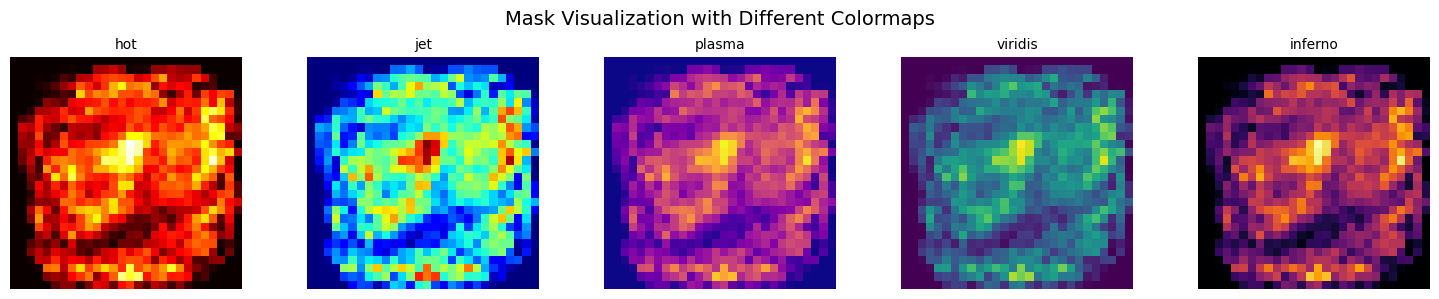

In [ ]:

def generate_saliency(model, image, label):
    image_tensor = tf.convert_to_tensor(image.reshape(1, -1), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        true_class_prob = predictions[0, label]
    gradient = tape.gradient(true_class_prob, image_tensor)
    saliency = tf.abs(gradient)
    return saliency.numpy().reshape(28, 28)

saliency_maps = []
for i in range(len(test_images_flat)):
    image = test_images_flat[i]
    label = test_labels[i] 
    saliency = generate_saliency(final_model, image, label)
    saliency_maps.append(saliency)
saliency_maps = np.array(saliency_maps)

def get_top_15_percent_mask(saliency_maps, percent=0.15):
    masks = []
    for saliency in saliency_maps:
        flat_saliency = saliency.flatten()
        threshold = np.percentile(flat_saliency, 100 - (percent * 100))
        mask = (saliency >= threshold).astype(np.float32)
        masks.append(mask)
    return np.array(masks)

top_15_masks = get_top_15_percent_mask(saliency_maps)

mean_mask = np.mean(top_15_masks, axis=0)
mean_mask = (mean_mask - mean_mask.min()) / (mean_mask.max() - mean_mask.min())

colormaps = ['hot', 'jet', 'plasma', 'viridis', 'inferno']

plt.figure(figsize=(15, 3))  

for i, cmap in enumerate(colormaps):
    plt.subplot(1, len(colormaps), i + 1) 
    plt.imshow(mean_mask, cmap=cmap)
    plt.title(cmap, fontsize=10)
    plt.axis('off')

plt.suptitle("Mask Visualization with Different Colormaps", fontsize=14)
plt.tight_layout()
plt.show()



219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


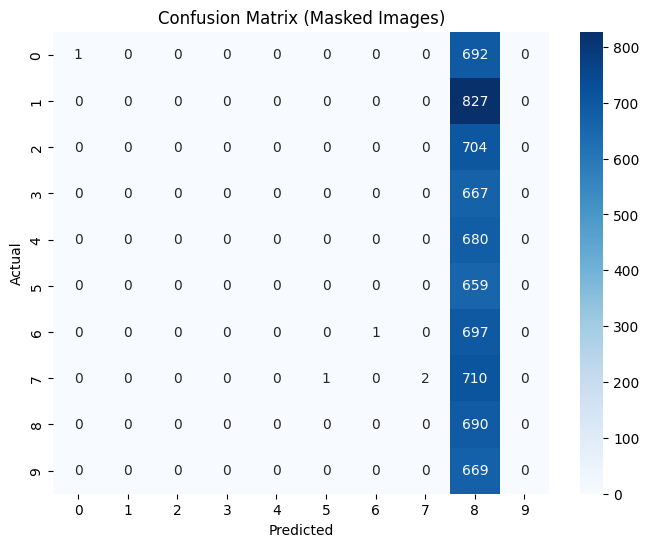


After applying the mean mask:
Test Accuracy: 9.91%
Precision (Macro): 0.3099
Recall (Macro): 0.1006
F1 Score (Macro): 0.0191


In [ ]:
test_images_reshaped = test_images_flat.reshape(-1, 28, 28)
masked_images = test_images_reshaped + mean_mask
masked_images = np.clip(masked_images, 0, 1)
masked_images_flat = masked_images.reshape(-1, 784)

masked_predictions = final_model.predict(masked_images_flat)
masked_pred_labels = np.argmax(masked_predictions, axis=1)

accuracy_masked = final_model.evaluate(masked_images_flat, test_labels_one_hot, verbose=0)[1]
precision_masked = precision_score(test_labels, masked_pred_labels, average='macro')
recall_masked = recall_score(test_labels, masked_pred_labels, average='macro')
f1_masked = f1_score(test_labels, masked_pred_labels, average='macro')

cm_masked = confusion_matrix(test_labels, masked_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_masked, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Masked Images)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nAfter applying the mean mask:")
print(f"Test Accuracy: {accuracy_masked*100:.2f}%")
print(f"Precision (Macro): {precision_masked:.4f}")
print(f"Recall (Macro): {recall_masked:.4f}")
print(f"F1 Score (Macro): {f1_masked:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


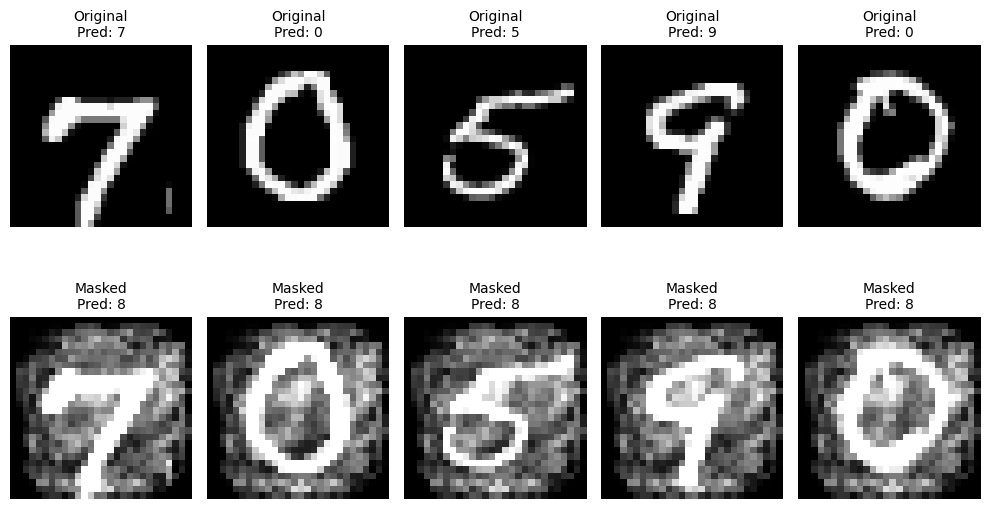

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


num_samples = 5
sample_indices = np.random.choice(len(test_images_flat), num_samples, replace=False)

original_predictions = final_model.predict(test_images_flat[sample_indices])
masked_predictions = final_model.predict(masked_images_flat[sample_indices])

original_pred_labels = np.argmax(original_predictions, axis=1)
masked_pred_labels = np.argmax(masked_predictions, axis=1)

plt.figure(figsize=(10, 6)) 

for i, idx in enumerate(sample_indices):
    original_image = test_images_flat[idx].reshape(28, 28)
    masked_image = masked_images_flat[idx].reshape(28, 28)

    # نمایش تصویر اصلی
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original\nPred: {original_pred_labels[i]}", fontsize=10)
    plt.axis('off')

    # نمایش تصویر ماسک‌شده
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(masked_image, cmap='gray')
    plt.title(f"Masked\nPred: {masked_pred_labels[i]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# **شبه در سوال**

# **بخش چ - 2**



📊 Samples Before and After F GSM Attack:
Sample 0: True = 9 | Original Prediction = 3 | Post-Attack Prediction = 3
Sample 1: True = 8 | Original Prediction = 8 | Post-Attack Prediction = 9
Sample 2: True = 1 | Original Prediction = 1 | Post-Attack Prediction = 8
Sample 3: True = 4 | Original Prediction = 4 | Post-Attack Prediction = 4
Sample 4: True = 5 | Original Prediction = 5 | Post-Attack Prediction = 8
Sample 5: True = 5 | Original Prediction = 5 | Post-Attack Prediction = 2
Sample 6: True = 1 | Original Prediction = 1 | Post-Attack Prediction = 2
Sample 7: True = 0 | Original Prediction = 0 | Post-Attack Prediction = 8
Sample 8: True = 1 | Original Prediction = 1 | Post-Attack Prediction = 2
Sample 9: True = 0 | Original Prediction = 0 | Post-Attack Prediction = 0


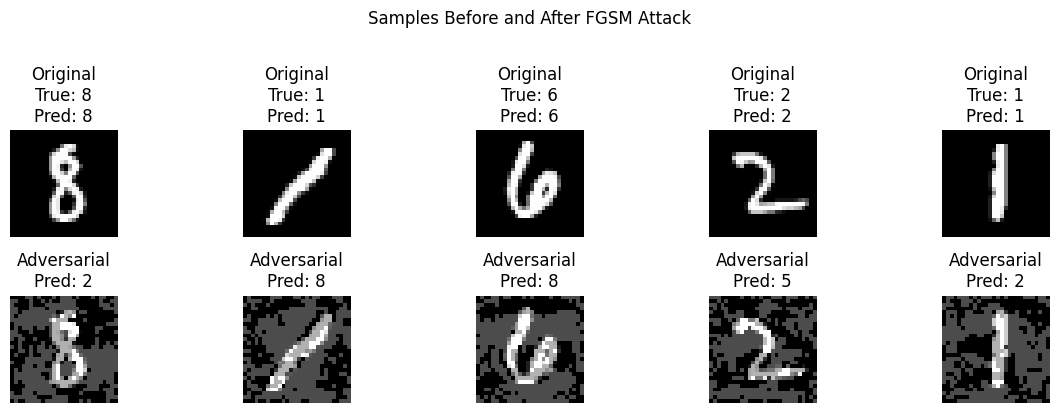


📊 Performance Evaluation (Original Images):
Accuracy: 0.9769
Precision: 0.9769
Recall: 0.9766
F1-Score: 0.9767


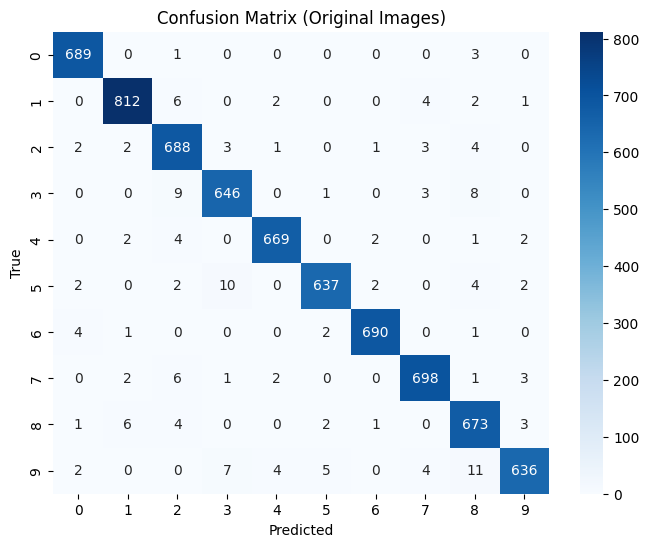


📊 Performance Evaluation (FGSM Attack):
Accuracy: 0.2180
Precision: 0.3538
Recall: 0.2222
F1-Score: 0.2398


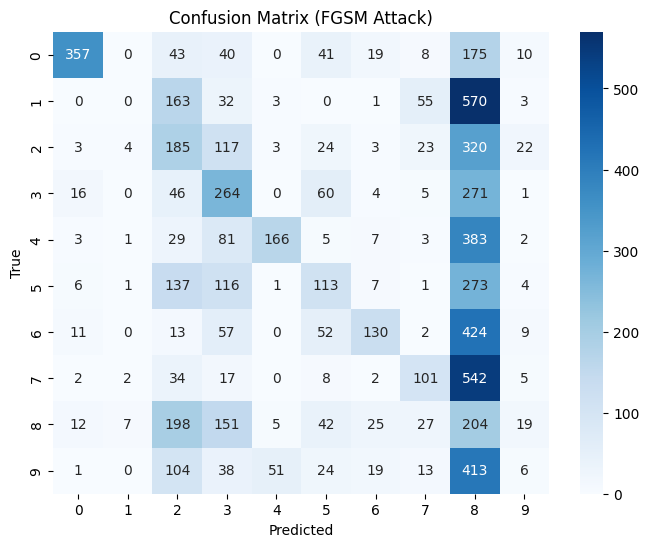


📊 Performance Evaluation (Unit Mask):
Accuracy: 0.8787
Precision: 0.9099
Recall: 0.8770
F1-Score: 0.8826


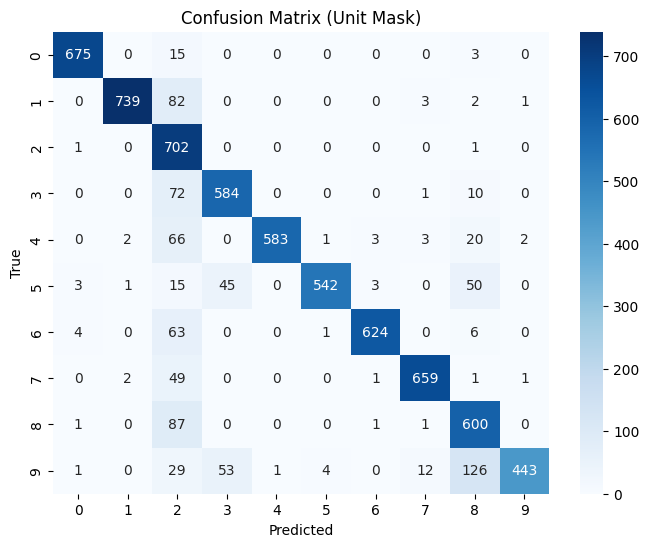

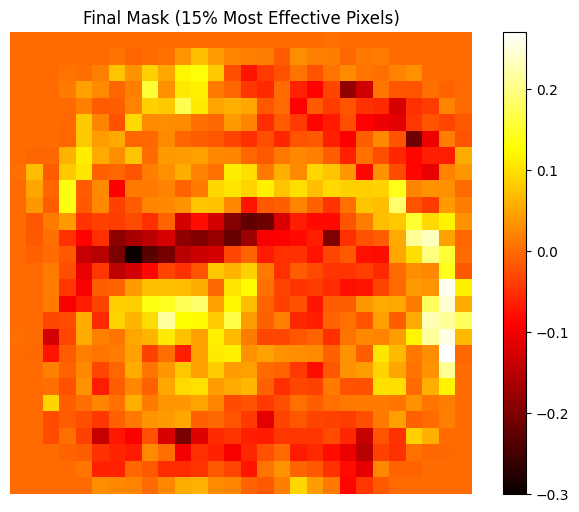

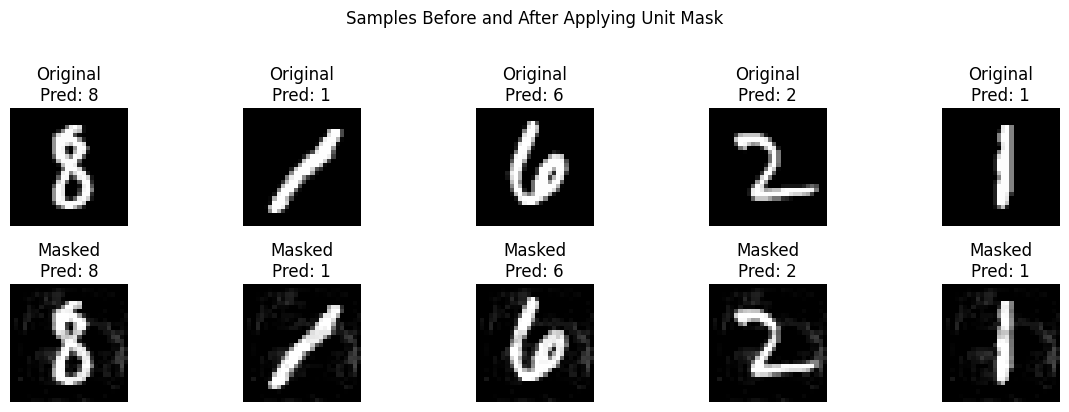

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

epsilon = 0.3  

def fgsm_attack(model, images, labels, epsilon):
    images = tf.Variable(images, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradients = tape.gradient(loss, images)
    perturbations = epsilon * tf.sign(gradients)
    adversarial_images = images + perturbations
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)
    return adversarial_images.numpy()

adversarial_images = fgsm_attack(final_model, test_images_flat, test_labels, epsilon)

y_pred_original = np.argmax(final_model.predict(test_images_flat, verbose=0), axis=1)
y_pred_adversarial = np.argmax(final_model.predict(adversarial_images, verbose=0), axis=1)

print("\n📊 Samples Before and After F GSM Attack:")
for i in range(10):
    true = test_labels[i]
    pred_orig = y_pred_original[i]
    pred_adv = y_pred_adversarial[i]
    print(f"Sample {i}: True = {true} | Original Prediction = {pred_orig} | Post-Attack Prediction = {pred_adv}")

num_samples = 5
sample_indices = np.random.choice(len(test_images_flat), num_samples, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(sample_indices):
    # Original image
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(test_images_flat[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Original\nTrue: {test_labels[idx]}\nPred: {y_pred_original[idx]}")
    plt.axis('off')

    # Adversarial image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(adversarial_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Adversarial\nPred: {y_pred_adversarial[idx]}")
    plt.axis('off')
plt.suptitle("Samples Before and After FGSM Attack", y=1.02)
plt.tight_layout()
plt.show()

def compute_gradients(model, images, labels):
    images = tf.Variable(images, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    return tape.gradient(loss, images).numpy()

grads = compute_gradients(final_model, test_images_flat, test_labels)

def top_15_mask(grad):
    abs_grad = np.abs(grad)
    threshold = np.percentile(abs_grad, 85)
    return np.where(abs_grad >= threshold, grad, 0)

masked_grads = np.array([top_15_mask(g) for g in grads])

final_mask = np.mean(masked_grads, axis=0)

final_mask = (final_mask / np.max(np.abs(final_mask))) * epsilon

binary_mask = np.where(np.abs(final_mask) > 0, 1, 0)

test_masked_images = test_images_flat + (binary_mask * final_mask)
test_masked_images = np.clip(test_masked_images, 0, 1)

y_pred_masked = np.argmax(final_model.predict(test_masked_images, verbose=0), axis=1)

def print_metrics(y_true, y_pred, name):
    print(f"\n📊 Performance Evaluation ({name}):")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='macro'):.4f}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_metrics(test_labels, y_pred_original, "Original Images")
print_metrics(test_labels, y_pred_adversarial, "FGSM Attack")
print_metrics(test_labels, y_pred_masked, "Unit Mask")

plt.figure(figsize=(8, 6))
plt.imshow(final_mask.reshape(28, 28), cmap='hot')
plt.title('Final Mask (15% Most Effective Pixels)')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(test_images_flat[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Original\nPred: {y_pred_original[idx]}")
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(test_masked_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Masked\nPred: {y_pred_masked[idx]}")
    plt.axis('off')
plt.suptitle("Samples Before and After Applying Unit Mask", y=1.02)
plt.tight_layout()
plt.show()